In [56]:
from SupertypeTools import CGCalcMat, heatmap, SSE, hierarchical_cluster, Silhouette
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
# contact = [7,9,24,45,59,62,63,66,67,69,70,73,74,76,77,80,81,84,95,97,99,114,116,118,143,147,150,152,156,158,159,163,167,171] #MHCpan
# contactA = [5,7,9,24,25,34,45,59,63,66,67,70,74,77,80,81,84,97,99,113,114,116,123,133,143,146,147,152,155,156,159,160,163,167,171]
# contactB = [5,7,8,9,24,45,59,62,63,65,66,67,70,73,74,76,77,80,81,84,95,97,99,114,116,123,143,146,147,152,155,156,159,160,163,167,171]

# weight = {3:[7,9,24,45,62,63,66,67,70,74,77,80,81,84,95,97,99,116,118,143,147,159]}

#Hanneke W.M. van Deutekom and Can Kesmir 2015
contact = [7,9,24,45,59,63,66,67,69,70,74,76,77,80,95,97,99,114,116,152,156,158,163,167,171]
weight = {9.9:[63],7.6:[67],5.8:[116],5.4:[9],4.7:[97],4.6:[152],3.8:[167],3.7:[156],3.6:[74],3.2:[70],3:[80],2.9:[171],2.8:[45],2.7:[66],2.7:[77],2.4:[76],2.3:[114],2.1:[99],1.5:[163],1.5:[95],1.4:[59],1.4:[158],1.2:[69],1.2:[24],1:[7]}

## Tuning number of clusters

#### functions

In [57]:
def Tuning_N(StructureDistMat, BADistMat, Nmin, Nmax, StructSilhouette=False, BASilhouette=False):
    """
    return (StructSSE, BASSE, StructSilhouette, BASilhouette)
    """
    StructSSE = []
    BASSE = []
    Silhouette_S = []
    Silhouette_BA = []

    # dist_list = []

    for i in range(Nmin, Nmax+1):

        # initialize optional parameters
        BA_err = 'NA'
        SilhouetteScore = 'NA'
        BASilhouetteScore = 'NA'

        cluster, _ = hierarchical_cluster(StructureDistMat, N=i, L='complete', threshold=None)
        #complete average single
        groups = [i[1].index.tolist() for i in cluster.groupby(cluster)]
        # print(groups)
        
        Struct_err = SSE(StructureDistMat, groups)
        StructSSE.append(Struct_err)

        if BADistMat is not None:
            BA_err = SSE(BADistMat, groups)
            BASSE.append(BA_err)

        if StructSilhouette:
            SilhouetteScore = Silhouette(StructureDistMat, groups)
            Silhouette_S.append(SilhouetteScore)

        if BASilhouette:
            BASilhouetteScore = Silhouette(BADistMat, groups)
            Silhouette_BA.append(BASilhouetteScore)

        print(f"N={i}  SE: {Struct_err} / BE: {BA_err} / SS: {SilhouetteScore} / BS: {BASilhouetteScore}")

        # dist_list.append(dist)

    return StructSSE, BASSE, Silhouette_S, Silhouette_BA

def elbow_plot(Struct_Mat, BA_Mat, Additional_Bar_group:list=None, Nmin=1, Nmax=12):
    
    SSE_struct, SSE_BA = Tuning_N(Struct_Mat, BA_Mat, Nmin, Nmax)
    xx = range(Nmin, Nmax+1)

    lines = []
    labels = []

    fig, ax1 = plt.subplots(figsize=(6,10))
    ax2 = ax1.twinx()

    line1, = ax1.plot(xx, SSE_BA, c='b', marker='^', mfc='None', mec='b', ms='8', mew=3, alpha=0.6, label="NetMHCpan SSE")
    line2, = ax2.plot(xx, SSE_struct, c='g', marker='v', mfc='None', mec='g', ms='8', mew=3, alpha=0.6, label="Structure SSE")
    lines.append(line1)
    labels.append("NetMHCpan SSE")
    lines.append(line2)
    labels.append("Structure SSE")

    ax1.set_xlabel('Number of clusters', fontsize=20)
    ax1.set_xticks(range(1,Nmax+1,2))
    ax1.tick_params(axis='x', labelsize=16)
    
    ax1.set_ylabel('Binding peptide SSE', color='tab:blue', fontsize=20)
    ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=16)

    ax2.set_ylabel('Structure distance SSE', color='tab:green', fontsize=20)
    ax2.tick_params(axis='y', labelcolor='tab:green', labelsize=16)

    if Additional_Bar_group:
        for group in Additional_Bar_group:
            lines.append(ax1.bar(group[0], group[1], alpha=0.6, label=group[2], linewidth=2, edgecolor='b'))
            labels.append(f"{group[2]} (n={group[0]})")

    # ax1.legend()
    # ax2.legend()
    ax1.legend(lines, labels, prop={"size":16})
    ax1.grid(linestyle='--')

    # fig.legend()
    plt.show()

    return

BA_Mat = pd.read_csv("../BA_pred/top10_matrix.csv", index_col=0)

In [70]:
from sklearn.model_selection import ParameterGrid
grid = ParameterGrid({'sigma':[0.005,0.01,0.02,0.03,0.04,0.05,0.075,0.1],
                    'w':[1,2,5,10,20,40,80, 150]})
for param in grid:

    sigma=param['sigma']
    w=param['w']
    print(sigma, w)
    AMat = CGCalcMat("../HLA1_models/CG_DAT", "../Figures/Figure3_compare_to_existing_supertype/HLA-A.list", contact=contact, weight=weight, sigma=sigma, w=w)
    _, ASSE_BA, _, _ = Tuning_N(AMat, BA_Mat, 3, 3, StructSilhouette=False, BASilhouette=False)

    BMat = CGCalcMat("../HLA1_models/CG_DAT", "../Figures/Figure3_compare_to_existing_supertype/HLA-B.list", contact=contact, weight=weight, sigma=sigma,w=w)
    _, BSSE_BA, _, _ = Tuning_N(BMat, BA_Mat, 3, 3, StructSilhouette=False, BASilhouette=False)

    CMat = CGCalcMat("../HLA1_models/CG_DAT", "../Figures/Figure3_compare_to_existing_supertype/HLA-C.list", contact=contact, weight=weight, sigma=sigma, w=w)
    _, CSSE_BA, _, _ = Tuning_N(CMat, BA_Mat, 2, 2, StructSilhouette=False, BASilhouette=False)

# Doytchinova SSE:
# 7.441962380952381
# 16.95428888198758
# 3.6950365384615385

# Sidney SSE:
# 5.025194318181818
# 11.338682679738561

0.005 1
N=3  SE: 99.21234893563579 / BE: 7.26641212121212 / SS: NA / BS: NA
N=3  SE: 238.09685364161533 / BE: 15.914055829228245 / SS: NA / BS: NA
N=2  SE: 69.4601600299615 / BE: 3.651940350877193 / SS: NA / BS: NA
0.005 2
N=3  SE: 97.55559883069799 / BE: 7.065198095238095 / SS: NA / BS: NA
N=3  SE: 238.23100904450837 / BE: 15.914055829228245 / SS: NA / BS: NA
N=2  SE: 69.48182071831604 / BE: 3.651940350877193 / SS: NA / BS: NA
0.005 5
N=3  SE: 97.62565370755087 / BE: 7.065198095238095 / SS: NA / BS: NA
N=3  SE: 238.62823120789525 / BE: 15.914055829228245 / SS: NA / BS: NA
N=2  SE: 69.54605568286661 / BE: 3.651940350877193 / SS: NA / BS: NA
0.005 10
N=3  SE: 97.73760439146554 / BE: 7.065198095238095 / SS: NA / BS: NA
N=3  SE: 239.27370104479854 / BE: 15.914055829228245 / SS: NA / BS: NA
N=2  SE: 69.6512157459162 / BE: 3.651940350877193 / SS: NA / BS: NA
0.005 20
N=3  SE: 97.94554167433256 / BE: 7.065198095238095 / SS: NA / BS: NA
N=3  SE: 261.95558108510517 / BE: 17.1091581884058 / SS:

In [59]:
sigma=0.1
w=5

### HLA-A

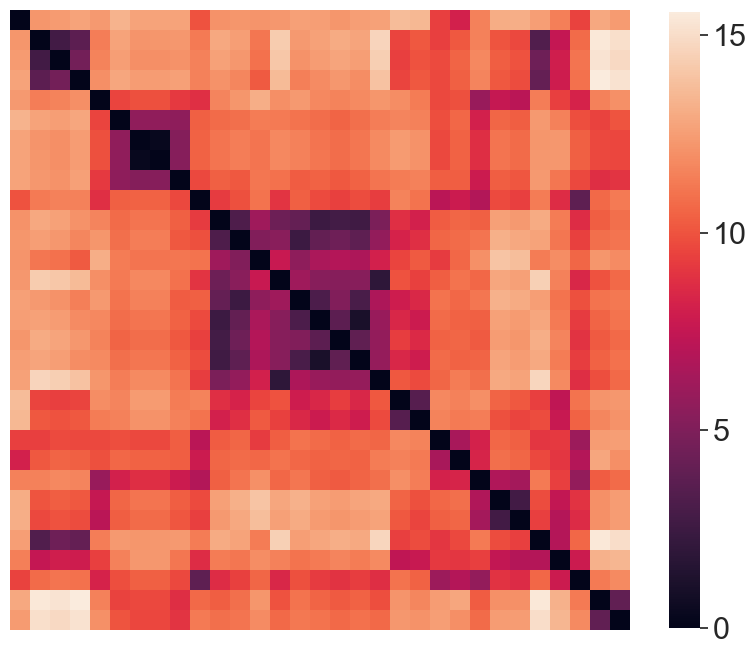

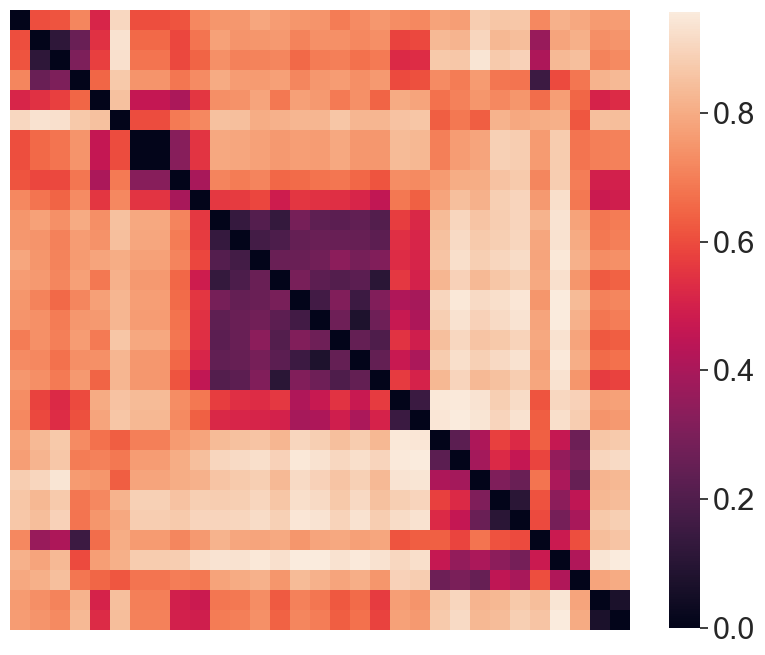

In [60]:
A_order = [
    ['A01_01', 'A26_01', 'A26_02', 'A26_03', 'A29_02', 'A30_01', 'A30_02', 'A30_03', 'A30_04', 'A32_01'],
    ['A02_01', 'A02_02', 'A02_03', 'A02_04', 'A02_05', 'A02_06', 'A02_07', 'A02_14', 'A02_17', 'A68_02', 'A69_01'],
    ['A03_01', 'A11_01', 'A31_01', 'A33_01', 'A33_03', 'A66_01', 'A68_01', 'A74_01'],
    ['A23_01', 'A24_02']
    ]
A_label = ['A*01:01', 'A*26:01', 'A*26:02', 'A*26:03', 'A*29:02', 'A*30:01', 'A*30:02', 'A*30:03', 'A*30:04', 'A*32:01', 'A*02:01', 'A*02:02', 'A*02:03', 'A*02:04', 'A*02:05', 'A*02:06', 'A*02:07', 'A*02:14', 'A*02:17', 'A*68:02', 'A*69:01', 'A*03:01', 'A*11:01', 'A*31:01', 'A*33:01', 'A*33:03', 'A*66:01', 'A*68:01', 'A*74:01', 'A*23:01', 'A*24:02']

AMat = CGCalcMat("../HLA1_models/CG_DAT", "../Figures/Figure3_compare_to_existing_supertype/HLA-A.list", contact=contact, weight=weight, sigma=sigma, w=w)
# AMat = CGCalcMat("../HLA1_models/CG_DAT", "../Figures/Figure3_compare_to_existing_supertype/HLA-A.list", contact=contact, weight=weight)
# heatmap(AMat, order=A_order, label=A_label, line=False, shrink=0.8, labelsize=12)
# heatmap(BA_Mat, order=A_order, label=A_label, line=False, shrink=0.8, labelsize=12)

sn.set(font_scale=2)
heatmap(AMat, order=A_order, line=False, shrink=0.8, labelsize=24, ticks=[0, 5, 10, 15, 20])
heatmap(BA_Mat, order=A_order, line=False, shrink=0.8, labelsize=24, ticks=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

In [61]:
# Sidney
A_Sidney = [
    ['A01_01', 'A26_01', 'A26_02', 'A26_03', 'A30_02', 'A30_03', 'A30_04', 'A32_01'],
    ['A30_01'],
    ['A29_02'],
    ['A02_01', 'A02_02', 'A02_03', 'A02_04', 'A02_05', 'A02_06', 'A02_07', 'A02_14', 'A02_17', 'A68_02', 'A69_01'],
    ['A03_01', 'A11_01', 'A31_01', 'A33_01', 'A33_03', 'A66_01', 'A68_01', 'A74_01'],
    ['A23_01', 'A24_02']
    ]

# Doytchinova
A_Doytchinova = [
    ['A01_01','A29_02','A30_01','A30_02','A30_03','A30_04','A32_01','A03_01','A11_01','A31_01','A33_01','A33_03','A66_01','A68_01','A74_01'],
    ['A26_01','A26_02','A26_03','A02_01','A02_02','A02_03','A02_04','A02_05','A02_06','A02_07','A02_14','A02_17','A68_02','A69_01'],
    ['A23_01','A24_02']
]
# elbow_plot(Mat, BA_Mat)
ASidney_SSE = SSE(BA_Mat, A_Sidney)
ADoytchinova_SSE = SSE(BA_Mat, A_Doytchinova)

ASidney_Silhouette = Silhouette(BA_Mat, A_Sidney)
ADoytchinov_Silhouette = Silhouette(BA_Mat, A_Doytchinova)

ASSE_struct, ASSE_BA, ASilhouette_struct, ASilhouette_struct_BA = Tuning_N(AMat, BA_Mat, 1, 12, StructSilhouette=True, BASilhouette=True)

# elbow_plot(AMat, BA_Mat, [(len(A_Doytchinova),ADoytchinova_SSE, "Doytchinova"), (len(A_Sidney),ASidney_SSE, "Sidney")])
print(f"Sidney SSE:{ASidney_SSE}, Silhouette_coefficient:{ASidney_Silhouette}\nDoytchinova SSE:{ADoytchinova_SSE}, Silhouette_coefficient:{ADoytchinov_Silhouette}")
# elbow_plot(Mat, BA_Mat)

N=1  SE: 152.8991050379498 / BE: 10.189367741935484 / SS: 0 / BS: 0
N=2  SE: 130.738384216764 / BE: 9.011758636363638 / SS: 0.20499201789970412 / BS: 0.1603441079841287
N=3  SE: 116.1891132997301 / BE: 8.084030303030302 / SS: 0.20718064143062404 / BS: 0.1475172594555121
N=4  SE: 95.16075216058056 / BE: 6.638943636363637 / SS: 0.3089515723072888 / BS: 0.23794889207448913
N=5  SE: 83.11290203062674 / BE: 5.517593333333334 / SS: 0.3408543385018498 / BS: 0.2935435783062406
N=6  SE: 73.19935138314254 / BE: 4.919810000000001 / SS: 0.3825392927341387 / BS: 0.3190409658711361
N=7  SE: 64.20316270784039 / BE: 4.2391266666666665 / SS: 0.4254587593905719 / BS: 0.37754777137600587
N=8  SE: 58.740079283808555 / BE: 3.783396666666667 / SS: 0.4184412657210232 / BS: 0.38250974214630373
N=9  SE: 53.467981464172034 / BE: 3.4636666666666667 / SS: 0.4106515445169076 / BS: 0.37743202509068313
N=10  SE: 49.24240768584885 / BE: 3.3146375 / SS: 0.3656505722164497 / BS: 0.25978003557474905
N=11  SE: 44.8336378

### HLA-B

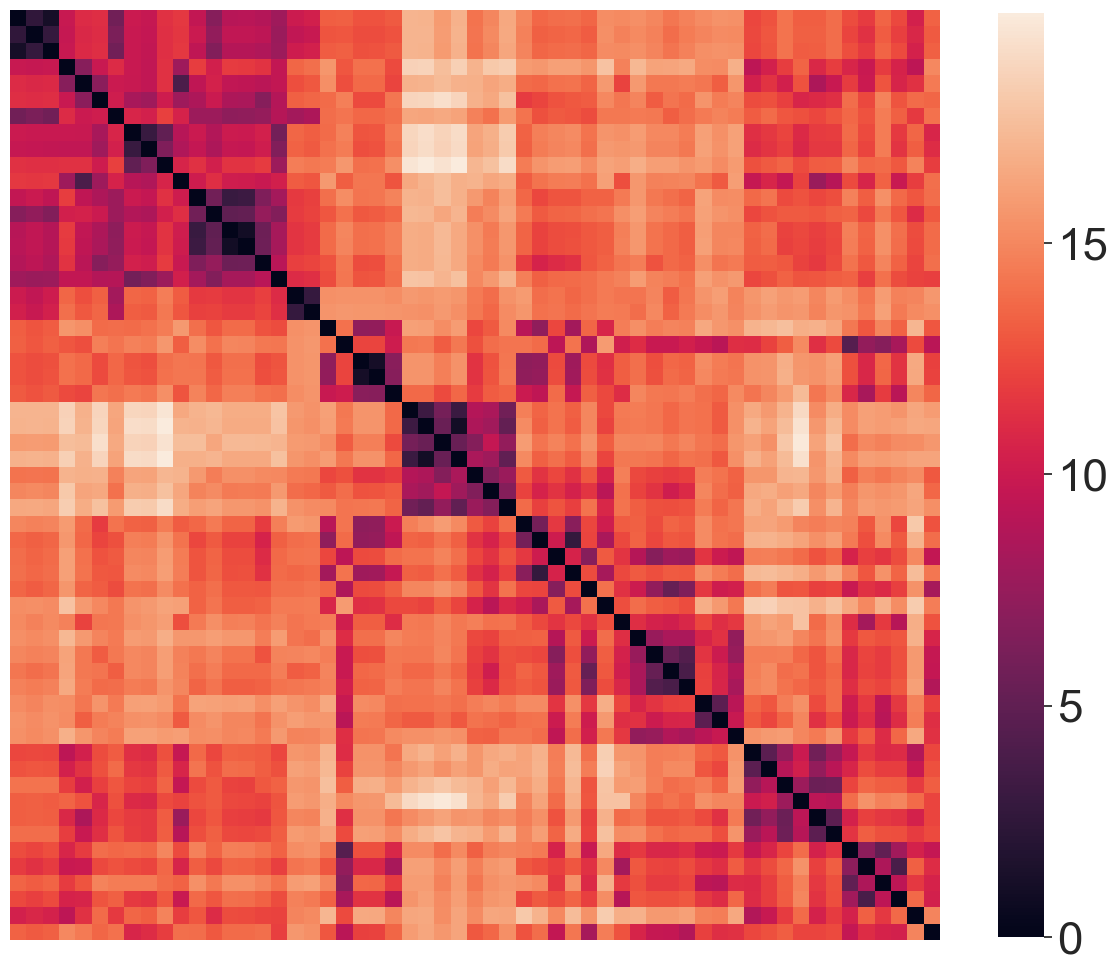

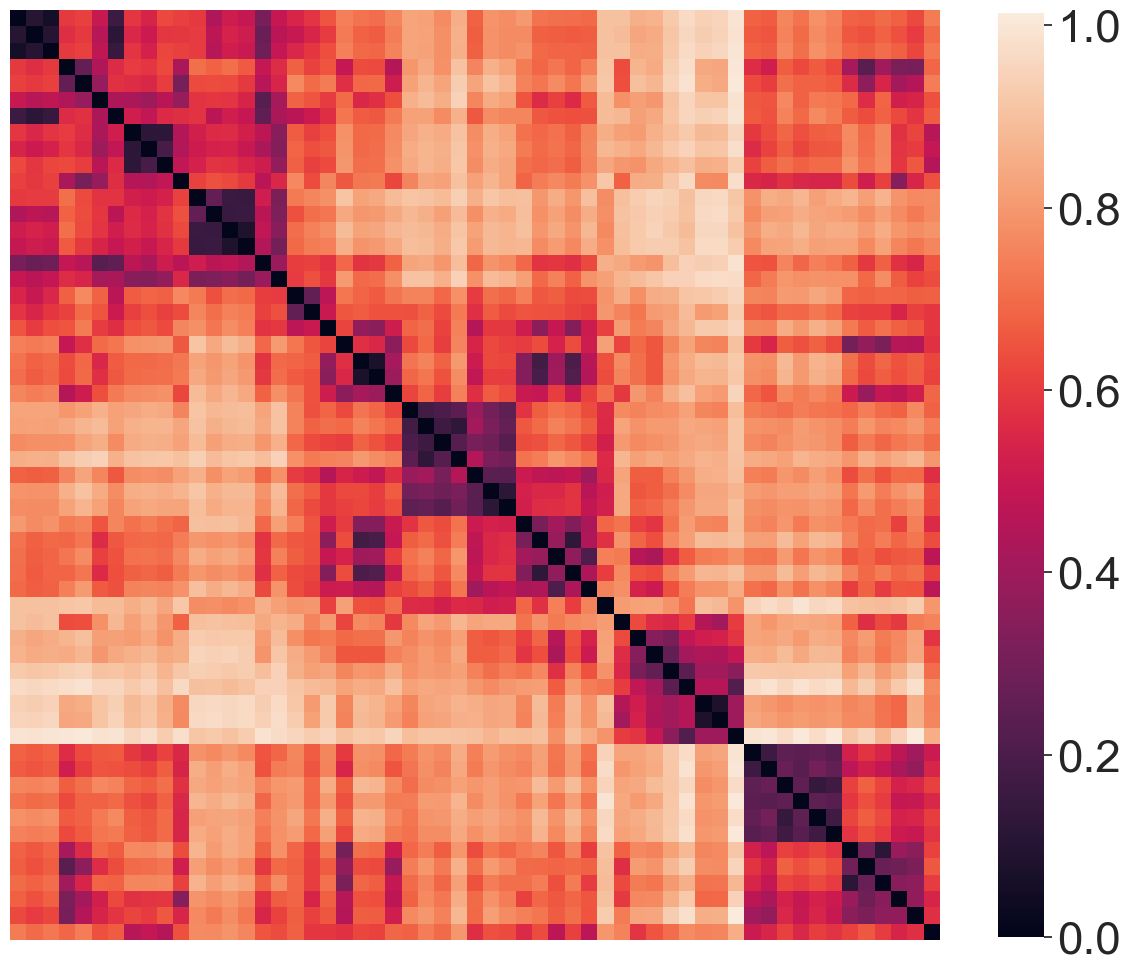

In [62]:
B_order = [
    ['B07_02','B07_03','B07_05','B15_08','B35_01','B35_03','B42_01','B51_01','B51_02','B51_03','B53_01','B54_01','B55_01','B55_02','B56_01','B67_01','B78_01'],
    ['B08_01','B08_02'],
    ['B14_02','B15_03','B15_09','B15_10','B15_18','B27_02','B27_03','B27_04','B27_05','B27_06','B27_07','B27_09','B38_01','B39_01','B39_02','B39_09','B48_01','B73_01'],
    ['B18_01','B37_01','B40_01','B40_02','B40_06','B44_02','B44_03','B45_01'],
    ['B15_16','B15_17','B57_01','B57_02','B58_01','B58_02'],
    ['B15_01','B15_02','B15_12','B15_13','B46_01','B52_01']
    ]
B_label = ['B*07:02','B*07:03','B*07:05','B*15:08','B*35:01','B*35:03','B*42:01','B*51:01','B*51:02','B*51:03','B*53:01','B*54:01','B*55:01','B*55:02','B*56:01','B*67:01','B*78:01','B*08:01','B*08:02','B*14:02','B*15:03','B*15:09','B*15:10','B*15:18','B*27:02','B*27:03','B*27:04','B*27:05','B*27:06','B*27:07','B*27:09','B*38:01','B*39:01','B*39:02','B*39:09','B*48:01','B*73:01','B*18:01','B*37:01','B*40:01','B*40:02','B*40:06','B*44:02','B*44:03','B*45:01','B*15:16','B*15:17','B*57:01','B*57:02','B*58:01','B*58:02','B*15:01','B*15:02','B*15:12','B*15:13','B*46:01','B*52:01']

BMat = CGCalcMat("../HLA1_models/CG_DAT", "../Figures/Figure3_compare_to_existing_supertype/HLA-B.list", contact=contact, weight=weight, sigma=sigma,w=w)
# BMat = CGCalcMat("../HLA1_models/CG_DAT", "../Figures/Figure3_compare_to_existing_supertype/HLA-B.list", contact=contact, weight=weight)
# heatmap(BMat, order=B_order, size=(16,16), label=B_label, line=False, shrink=0.8, labelsize=12)
# heatmap(BA_Mat, order=B_order, size=(16,16), label=B_label, line=False, shrink=0.8, labelsize=12)

sn.set(font_scale=3)
heatmap(BMat, order=B_order, size=(15,15), line=False, shrink=0.8, labelsize=12, ticks=[0, 5, 10, 15, 20])
heatmap(BA_Mat, order=B_order, size=(15,15), line=False, shrink=0.8, labelsize=12, ticks=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

In [63]:
# Sidney
B_Sidney = [
    ['B07_02','B07_03','B07_05','B15_08','B35_01','B35_03','B42_01','B51_01','B51_02','B51_03','B53_01','B54_01','B55_01','B55_02','B56_01','B67_01','B78_01'],
    ['B08_01','B08_02'],
    ['B14_02','B15_03','B15_09','B15_10','B15_18','B27_02','B27_03','B27_04','B27_05','B27_06','B27_07','B27_09','B38_01','B39_01','B39_02','B39_09','B48_01','B73_01'],
    ['B18_01','B37_01','B40_01','B40_02','B40_06','B44_02','B44_03','B45_01'],
    ['B15_16','B15_17','B57_01','B57_02','B58_01','B58_02'],
    ['B15_01','B15_02','B15_12','B15_13','B46_01','B52_01']
    ]
# Doytchinova
B_Doytchinova = [
    ['B07_02','B07_03','B07_05','B15_08','B35_01','B35_03','B42_01','B54_01','B55_01','B55_02','B56_01','B67_01','B78_01','B08_01','B14_02','B15_09','B15_10','B15_18','B39_01','B39_09','B73_01','B18_01','B15_02'],
    ['B51_01','B51_02','B51_03','B53_01','B08_02','B27_02','B38_01','B44_02','B44_03','B57_01','B57_02','B58_01','B58_02','B52_01'],
    ['B15_03','B27_03','B27_04','B27_05','B27_06','B27_07','B27_09','B39_02','B48_01','B37_01','B40_01','B40_02','B40_06','B45_01','B15_16','B15_17','B15_01','B15_12','B15_13','B46_01']
]

BSidney_SSE = SSE(BA_Mat, B_Sidney)
BDoytchinova_SSE = SSE(BA_Mat, B_Doytchinova)

BSidney_Silhouette = Silhouette(BA_Mat, B_Sidney)
BDoytchinov_Silhouette = Silhouette(BA_Mat, B_Doytchinova)

BSSE_struct, BSSE_BA, BSilhouette_struct, BSilhouette_struct_BA = Tuning_N(BMat, BA_Mat, 1, 12, StructSilhouette=True, BASilhouette=True)
# elbow_plot(BMat, BA_Mat, [(len(B_Doytchinova),BDoytchinova_SSE, "Doytchinova"), (len(B_Sidney),BSidney_SSE, "Sidney")])
print(f"Sidney SSE:{BSidney_SSE}, Silhouette_coefficient:{BSidney_Silhouette}\nDoytchinova SSE:{BDoytchinova_SSE}, Silhouette_coefficient:{BDoytchinov_Silhouette}")

N=1  SE: 368.75119714335455 / BE: 19.488978947368423 / SS: 0 / BS: 0
N=2  SE: 314.66383068360636 / BE: 16.78469441687345 / SS: 0.22478192283934392 / BS: 0.20828425208475784
N=3  SE: 282.0011251071846 / BE: 15.159718717948719 / SS: 0.24447909012259011 / BS: 0.22386239518748266
N=4  SE: 259.06754993619916 / BE: 13.44313679197995 / SS: 0.24774737444353356 / BS: 0.2578308110634689
N=5  SE: 232.4136619440178 / BE: 12.21002810150376 / SS: 0.2976776379187897 / BS: 0.28535006990895595
N=6  SE: 219.7311722404468 / BE: 11.570890021008404 / SS: 0.3008881336908839 / BS: 0.2862586481327217
N=7  SE: 212.9360965953032 / BE: 11.243082878151261 / SS: 0.28654577426211664 / BS: 0.22375919709677378
N=8  SE: 197.60312176284236 / BE: 10.31658287815126 / SS: 0.29252646813826777 / BS: 0.23711287782195106
N=9  SE: 191.28768033369337 / BE: 9.885552521008403 / SS: 0.26541033371304185 / BS: 0.2366385528098182
N=10  SE: 182.65954871442383 / BE: 9.601767521008403 / SS: 0.2656157605795562 / BS: 0.23037368121000265
N

### HLA-C

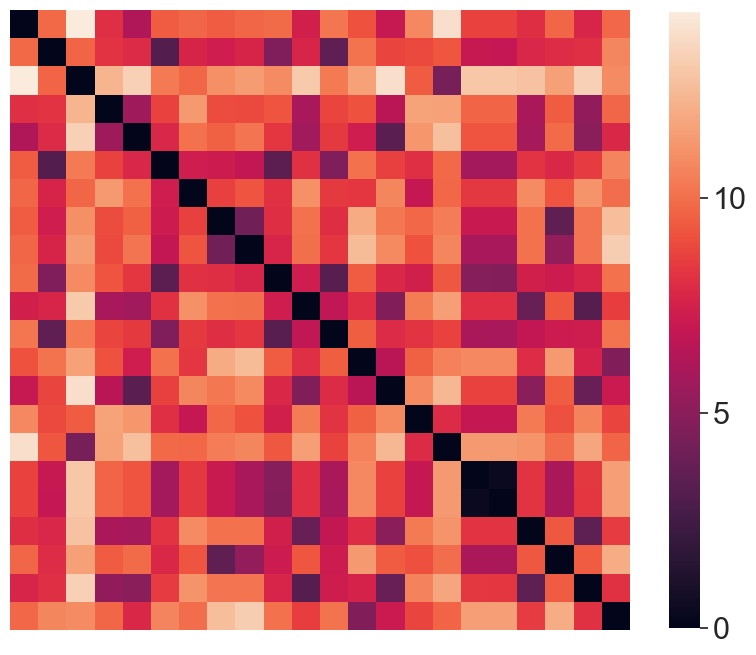

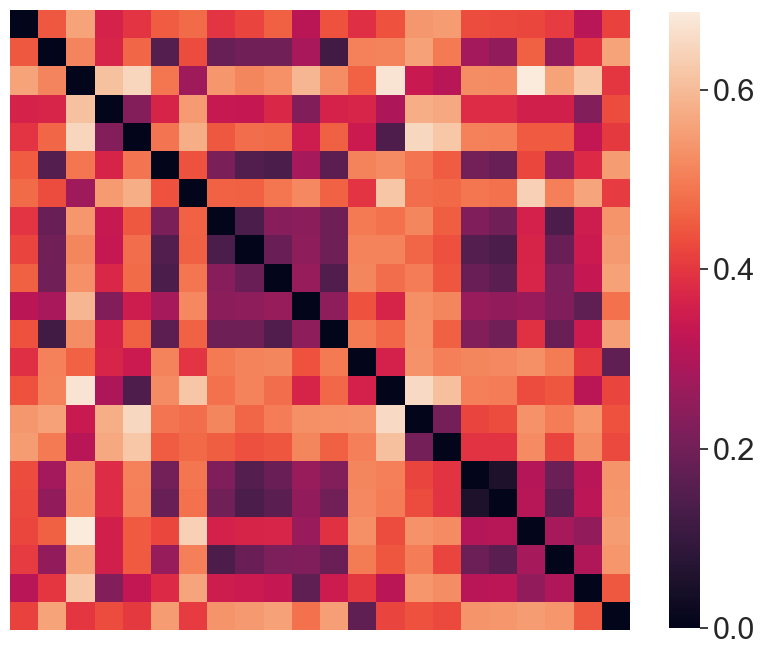

In [64]:
C_order = [
    ['C01_02','C03_02','C07_02','C08_01','C08_02','C12_02','C14_02','C16_01','C16_04'],
    ['C02_02','C03_07','C03_15','C04_01','C05_01','C06_02','C07_07','C12_04','C12_05','C15_02','C16_02','C17_01','C18_01']
]
C_label = ['C*01:02','C*03:02','C*07:02','C*08:01','C*08:02','C*12:02','C*14:02','C*16:01','C*16:04','C*02:02','C*03:07','C*03:15','C*04:01','C*05:01','C*06:02','C*07:07','C*12:04','C*12:05','C*15:02','C*16:02','C*17:01','C*18:01']

CMat = CGCalcMat("../HLA1_models/CG_DAT", "../Figures/Figure3_compare_to_existing_supertype/HLA-C.list", contact=contact, weight=weight, sigma=sigma, w=w)
# CMat = CGCalcMat("../HLA1_models/CG_DAT", "../Figures/Figure3_compare_to_existing_supertype/HLA-C.list", contact=contact, weight=weight)
# heatmap(CMat, order=C_order, label=C_label, line=False, shrink=0.8, labelsize=12)
# heatmap(BA_Mat, order=C_order, label=C_label, line=False, shrink=0.8, labelsize=12)

sn.set(font_scale=2)
heatmap(CMat, order=C_order, line=False, shrink=0.8, labelsize=12, ticks=[0, 5, 10, 15, 20])
heatmap(BA_Mat, order=C_order, line=False, shrink=0.8, labelsize=12, ticks=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

In [65]:
# Doytchinova
C_Doytchinova = [
    ['C01_02','C03_02','C07_02','C08_01','C12_02','C14_02','C16_01','C16_04'],
    ['C02_02','C03_07','C03_15','C04_01','C05_01','C06_02','C07_07','C12_04','C12_05','C15_02','C16_02','C17_01','C18_01']
]
CDoytchinova_SSE = SSE(BA_Mat, C_Doytchinova)

CDoytchinov_Silhouette = Silhouette(BA_Mat, C_Doytchinova)

CSSE_struct, CSSE_BA, CSilhouette_struct, CSilhouette_struct_BA = Tuning_N(CMat, BA_Mat, 1, 12, StructSilhouette=True, BASilhouette=True)
# elbow_plot(CMat, BA_Mat, [(len(C_Doytchinova),CDoytchinova_SSE, "Doytchinova")])
print(f"Doytchinova SSE:{CDoytchinova_SSE}, Silhouette_coefficient:{CDoytchinov_Silhouette}")

N=1  SE: 91.13252848902448 / BE: 4.201759090909092 / SS: 0 / BS: 0
N=2  SE: 72.78526238185545 / BE: 3.4180735042735044 / SS: 0.27117371838207505 / BS: 0.25503716984794655
N=3  SE: 62.18462112744582 / BE: 3.0060070707070707 / SS: 0.3156178267385885 / BS: 0.23089968873630423
N=4  SE: 54.92921199177366 / BE: 2.6197253246753247 / SS: 0.31455882831389476 / BS: 0.2508353463238579
N=5  SE: 48.440702350949486 / BE: 2.165946031746032 / SS: 0.3203637599975995 / BS: 0.2725078351949573
N=6  SE: 40.82641374305688 / BE: 2.0236404761904763 / SS: 0.3426305845330944 / BS: 0.10171270838226959
N=7  SE: 36.2199479493116 / BE: 1.80715 / SS: 0.3339504192168054 / BS: 0.10606342821532638
N=8  SE: 30.377586922912016 / BE: 1.6183166666666668 / SS: 0.37126599052107934 / BS: 0.16506974773142383
N=9  SE: 26.902693047414303 / BE: 1.3803666666666667 / SS: 0.3628459083218027 / BS: 0.17053002010540974
N=10  SE: 23.45975891350203 / BE: 1.26088 / SS: 0.32902279947547186 / BS: 0.10785300090236372
N=11  SE: 19.86890845427

In [66]:
# random clustering as baseline
import random
import numpy as np

A_ref_alleles = ['A01_01', 'A26_01', 'A26_02', 'A26_03', 'A29_02', 'A30_01', 'A30_02', 'A30_03', 'A30_04', 'A32_01',
'A02_01', 'A02_02', 'A02_03', 'A02_04', 'A02_05', 'A02_06', 'A02_07', 'A02_14', 'A02_17', 'A68_02', 'A69_01',
'A03_01', 'A11_01', 'A31_01', 'A33_01', 'A33_03', 'A66_01', 'A68_01', 'A74_01',
'A23_01', 'A24_02']
B_ref_alleles = ['B07_02','B07_03','B07_05','B15_08','B35_01','B35_03','B42_01','B51_01','B51_02','B51_03','B53_01','B54_01','B55_01','B55_02','B56_01','B67_01','B78_01',
'B08_01','B08_02',
'B14_02','B15_03','B15_09','B15_10','B15_18','B27_02','B27_03','B27_04','B27_05','B27_06','B27_07','B27_09','B38_01','B39_01','B39_02','B39_09','B48_01','B73_01',
'B18_01','B37_01','B40_01','B40_02','B40_06','B44_02','B44_03','B45_01',
'B15_16','B15_17','B57_01','B57_02','B58_01','B58_02',
'B15_01','B15_02','B15_12','B15_13','B46_01','B52_01']
C_ref_alleles = ['C01_02','C03_02','C07_02','C08_01','C08_02','C12_02','C14_02','C16_01','C16_04',
'C02_02','C03_07','C03_15','C04_01','C05_01','C06_02','C07_07','C12_04','C12_05','C15_02','C16_02','C17_01','C18_01']
ALL_REF = [A_ref_alleles, B_ref_alleles, C_ref_alleles]

RAND_BA_SSE = []
RAND_BA_Silhouette = []
for ref_alleles in ALL_REF:
    mean_sse = []
    std_sse = []
    mean_silhouette = []
    std_silhouette = []

    for i in range(1, 13):
        n_cluster_sse = []
        n_cluster_silhouette = []
        for _ in range(5):
            random.shuffle(ref_alleles)
            rand_split = np.array_split(ref_alleles, i)
            # print(len(rand_split), ref_alleles)
            # breakpoint()
            n_cluster_sse.append(SSE(BA_Mat, rand_split))
            n_cluster_silhouette.append(Silhouette(BA_Mat, rand_split))
        mean_sse.append(np.mean(n_cluster_sse))
        std_sse.append(np.std(n_cluster_sse))

        mean_silhouette.append(np.mean(n_cluster_silhouette))
        std_silhouette.append(np.std(n_cluster_silhouette))

    RAND_BA_SSE.append((mean_sse, std_sse))
    RAND_BA_Silhouette.append((mean_silhouette, std_silhouette))

In [67]:
# clustering of BA matrix as best
BA_SSE = []
BA_Silhouette = []
for ref_alleles in ALL_REF:
    # mean_sse = []
    # mean_silhouette = []
    BA_ref_Mat = BA_Mat.loc[ref_alleles][ref_alleles]
    SSE_BA, _, Silhouette_BA, _ = Tuning_N(BA_ref_Mat, None, 1, 12, StructSilhouette=True, BASilhouette=False)

    BA_SSE.append(SSE_BA)
    BA_Silhouette.append(Silhouette_BA)

N=1  SE: 10.189367741935484 / BE: NA / SS: 0 / BS: NA
N=2  SE: 8.089065217391303 / BE: NA / SS: 0.32666221410724355 / BS: NA
N=3  SE: 6.557166666666667 / BE: NA / SS: 0.34969492461512014 / BS: NA
N=4  SE: 6.071980952380953 / BE: NA / SS: 0.33604824019121976 / BS: NA
N=5  SE: 5.166829437229438 / BE: NA / SS: 0.36540424907878366 / BS: NA
N=6  SE: 4.29197277056277 / BE: NA / SS: 0.42701061640601995 / BS: NA
N=7  SE: 3.92378777056277 / BE: NA / SS: 0.4330883704885289 / BS: NA
N=8  SE: 3.525223484848485 / BE: NA / SS: 0.4031283152137783 / BS: NA
N=9  SE: 2.943608333333333 / BE: NA / SS: 0.426433518477437 / BS: NA
N=10  SE: 2.6334416666666667 / BE: NA / SS: 0.43443517025183015 / BS: NA
N=11  SE: 2.355933333333333 / BE: NA / SS: 0.4387657602355196 / BS: NA
N=12  SE: 2.0890833333333334 / BE: NA / SS: 0.4481437048534411 / BS: NA
N=1  SE: 19.48897894736842 / BE: NA / SS: 0 / BS: NA
N=2  SE: 16.982274542682926 / BE: NA / SS: 0.2269180347364072 / BS: NA
N=3  SE: 15.088605792682927 / BE: NA / SS: 0

### combine all three subplots

#### SSE plot

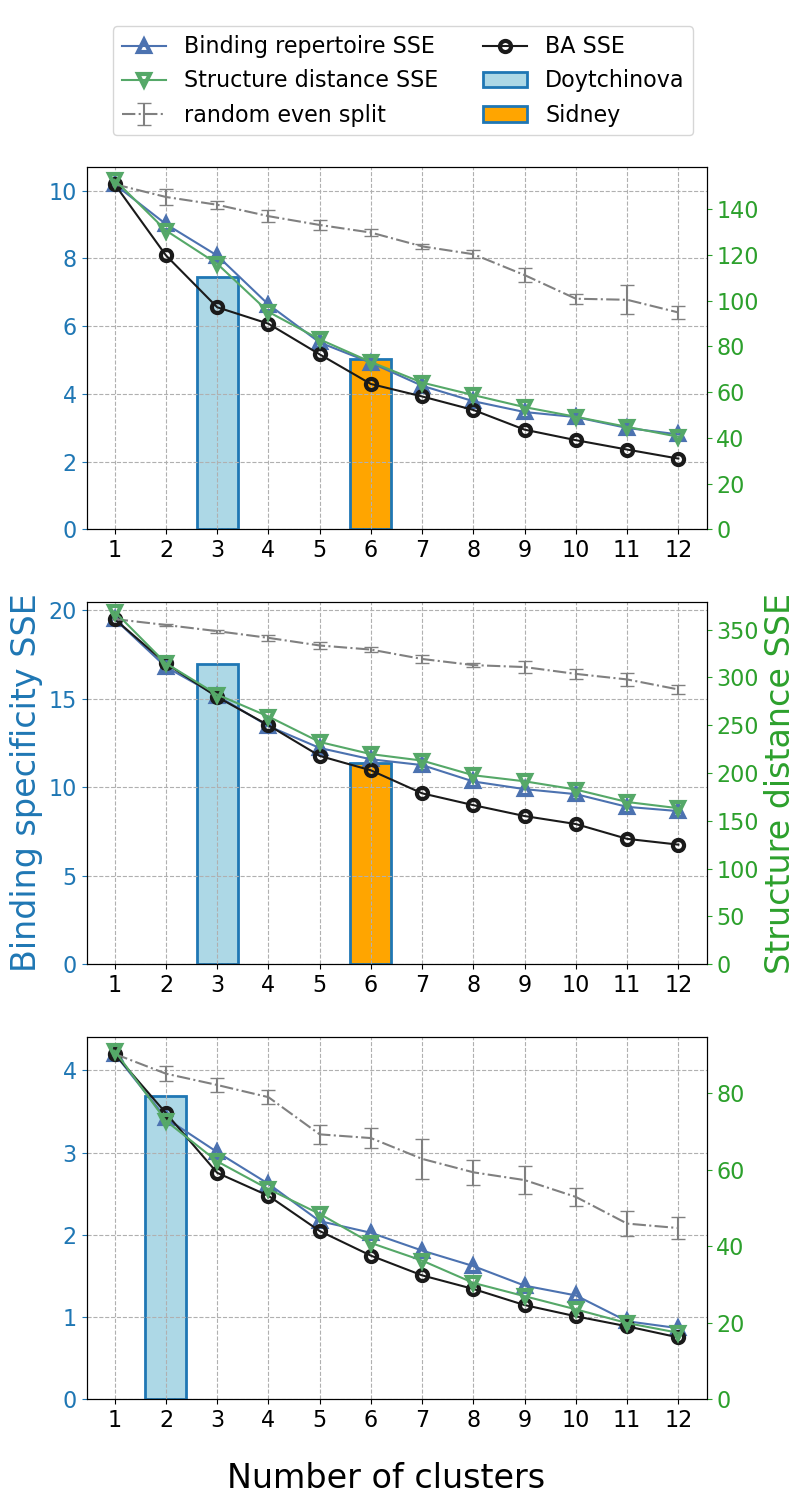

In [69]:
SSE_BA_list = [ASSE_BA, BSSE_BA, CSSE_BA]
SSE_struct_list = [ASSE_struct, BSSE_struct, CSSE_struct]
SSE_other = [((len(A_Doytchinova),ADoytchinova_SSE, "Doytchinova"), (len(A_Sidney),ASidney_SSE, "Sidney")), ((len(B_Doytchinova),BDoytchinova_SSE, "Doytchinova"), (len(B_Sidney),BSidney_SSE, "Sidney")), ((len(C_Doytchinova),CDoytchinova_SSE, "Doytchinova"),)]

xx = range(1, 13)
plt.style.use('default')
fig, axes = plt.subplots(3, 1, figsize=(8,16))
i=1
for ax1, SSE_BA, SSE_struct, SSE_random, SSE_BABA, Additional_Bar_group in zip(axes, SSE_BA_list, SSE_struct_list, RAND_BA_SSE, BA_SSE, SSE_other):

    # lines = []
    # labels = []
    ax2 = ax1.twinx()

    # line plots
    line1, = ax1.plot(xx, SSE_BA, c='b', marker='^', mfc='None', mec='b', ms='8', mew=3, alpha=1, label="Binding specificity SSE")
    line2, = ax2.plot(xx, SSE_struct, c='g', marker='v', mfc='None', mec='g', ms='8', mew=3, alpha=1, label="Structure distance SSE")
    # lines.append(line1)
    # labels.append("Binding peptide SSE")
    # lines.append(line2)
    # labels.append("Structure distance SSE")

    # random splits
    randoms = ax1.errorbar(xx, SSE_random[0], yerr=SSE_random[1], alpha=1, ls='-.', capsize=5, color='gray', label="random even split")
    line3, = ax1.plot(xx, SSE_BABA, c='k', marker='o', mfc='None', mec='k', ms='8', mew=3, alpha=1, label="Binding specificity SSE on BA")
    # lines.append(randoms)
    # labels.append("random even split SSE")

    # ax1.set_xlabel('Number of clusters', fontsize=20)
    ax1.set_xticks(range(1,13,1))
    ax1.tick_params(axis='x', labelsize=16)

    if i == 2:
        lines = []
        labels = []
        lines.append(line1)
        labels.append("Binding repertoire SSE")
        lines.append(line2)
        labels.append("Structure distance SSE")
        lines.append(randoms)
        labels.append("random even split")
        lines.append(line3)
        labels.append("BA SSE")

        ax1.set_ylabel('Binding specificity SSE', color='tab:blue', fontsize=24)
        ax2.set_ylabel('Structure distance SSE', color='tab:green', fontsize=24)
    

    ax1.tick_params(axis='y', colors='tab:blue', labelsize=16)
    ax2.tick_params(axis='y', colors='tab:green', labelsize=16)
    ax2.set_ylim([0,None])

    # bar plots
    for group, color in zip(Additional_Bar_group, ["lightblue","orange"]):
        # print(group)
        # lines.append(ax1.bar(group[0], group[1], alpha=0.6, label=group[2], linewidth=2, edgecolor='b'))
        # labels.append(f"{group[2]} (n={group[0]})")
        bar = ax1.bar(group[0], group[1], color=color, label=group[2], linewidth=2, edgecolor='tab:blue')

        if i == 2:
            lines.append(bar)
            labels.append(group[2])

    # ax1.legend(lines, labels, prop={"size":16}, loc=1)
    ax1.grid(linestyle='--')
    i += 1

fig.legend(lines, labels, prop={"size":16}, loc=(0.14,0.91), ncol=2)
fig.supxlabel("Number of clusters", fontsize=24, y=0.05)

plt.show()

#### silhouette plot

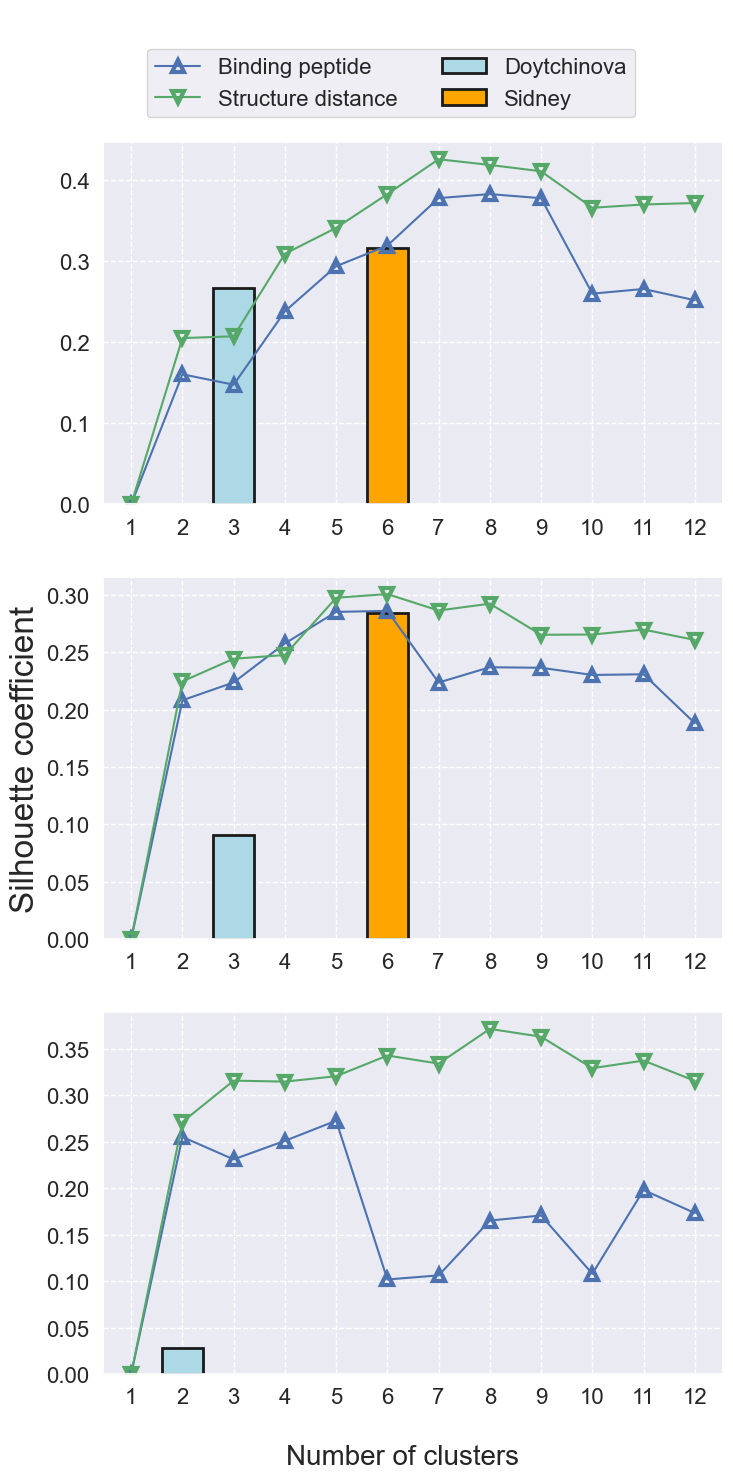

In [68]:
Silhouette_BA_list = [ASilhouette_struct_BA, BSilhouette_struct_BA, CSilhouette_struct_BA]
Silhouette_struct_list = [ASilhouette_struct, BSilhouette_struct, CSilhouette_struct]
Silhouette_other = [((len(A_Doytchinova),ADoytchinov_Silhouette, "Doytchinova"), (len(A_Sidney),ASidney_Silhouette, "Sidney")),
                    ((len(B_Doytchinova),BDoytchinov_Silhouette, "Doytchinova"), (len(B_Sidney),BSidney_Silhouette, "Sidney")),
                    ((len(C_Doytchinova),CDoytchinov_Silhouette, "Doytchinova"),)]

xx = range(1, 13)

fig, axes = plt.subplots(3, 1, figsize=(8,16))
i=1
for ax1, SSE_BA, SSE_struct, SSE_random, Additional_Bar_group in zip(axes, Silhouette_BA_list, Silhouette_struct_list, RAND_BA_Silhouette, Silhouette_other):

    # lines = []
    # labels = []
    # ax2 = ax1.twinx()

    # line plots
    line1, = ax1.plot(xx, SSE_BA, c='b', marker='^', mfc='None', mec='b', ms='8', mew=3, label="Binding peptide")
    line2, = ax1.plot(xx, SSE_struct, c='g', marker='v', mfc='None', mec='g', ms='8', mew=3, label="Structure distance")
    # lines.append(line1)
    # labels.append("Binding peptide SSE")
    # lines.append(line2)
    # labels.append("Structure distance SSE")

    # random splits
    # randoms = ax1.errorbar(xx, SSE_random[0], yerr=SSE_random[1], alpha=0.6, ls='-.', capsize=5, color='gray', label="random even split")
    # lines.append(randoms)
    # labels.append("random even split SSE")

    # ax1.set_xlabel('Number of clusters', fontsize=20)
    ax1.set_xticks(range(1,13,1))
    ax1.tick_params(axis='x', labelsize=16)

    if i == 2:
        lines = []
        labels = []
        lines.append(line1)
        labels.append("Binding peptide")
        lines.append(line2)
        labels.append("Structure distance")
        # lines.append(randoms)
        # labels.append("random even split")

        ax1.set_ylabel('Silhouette coefficient', fontsize=24)
        # ax2.set_ylabel('Structure distance SSE', color='tab:green', fontsize=24)
    

    ax1.tick_params(axis='y', labelsize=16)
    # ax2.tick_params(axis='y', labelcolor='tab:green', labelsize=16)

    # bar plots
    for group, color in zip(Additional_Bar_group, ["lightblue","orange"]):
        # print(group)
        # lines.append(ax1.bar(group[0], group[1], alpha=0.6, label=group[2], linewidth=2, edgecolor='b'))
        # labels.append(f"{group[2]} (n={group[0]})")
        bar = ax1.bar(group[0], group[1], color=color, label=group[2], linewidth=2, edgecolor='k')

        if i == 2:
            lines.append(bar)
            labels.append(group[2])

    # ax1.legend(lines, labels, prop={"size":16}, loc=1)
    ax1.grid(linestyle='--')
    i += 1

# fig.legend(lines, labels, prop={"size":16}, loc=9, ncol=2)
fig.legend(lines, labels, prop={"size":16}, loc=(0.2,0.92), ncol=2)
fig.supxlabel("Number of clusters", fontsize=20, y=0.05)

plt.show()

## All Binding Affinity data

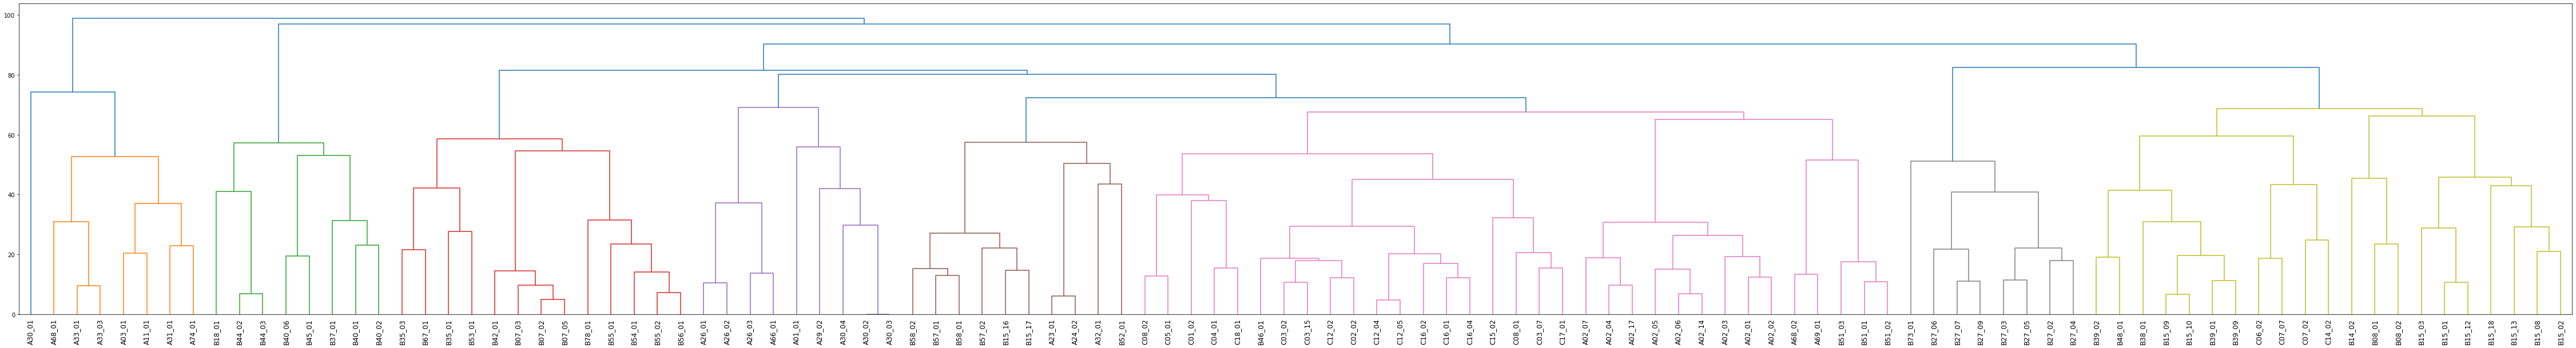

In [ ]:
cluster, order = hierarchical_cluster(BA_Mat, N=12, plot_dendro=True)

N=3  SE: 33.38481489361702 / BE: NA / SS: 0.2627922299766596 / BS: NA
N=4  SE: 30.83061387267905 / BE: NA / SS: 0.18933111577418282 / BS: NA
N=5  SE: 29.288908269230774 / BE: NA / SS: 0.17761776839855384 / BS: NA
N=6  SE: 27.05310288461539 / BE: NA / SS: 0.2163594037057559 / BS: NA
N=7  SE: 25.642420803518192 / BE: NA / SS: 0.23218985005634693 / BS: NA
N=8  SE: 25.157235089232476 / BE: NA / SS: 0.22913962113913858 / BS: NA
N=9  SE: 23.894772904595406 / BE: NA / SS: 0.23078683622935137 / BS: NA
N=10  SE: 23.01991623792874 / BE: NA / SS: 0.2455435218230347 / BS: NA
N=11  SE: 22.102208056110555 / BE: NA / SS: 0.2501042787201081 / BS: NA
N=12  SE: 20.13913842749356 / BE: NA / SS: 0.29154062621272575 / BS: NA
N=13  SE: 19.385285570350703 / BE: NA / SS: 0.29614604768583563 / BS: NA
N=14  SE: 18.266746522731655 / BE: NA / SS: 0.3171166681188088 / BS: NA
N=15  SE: 17.42207541883555 / BE: NA / SS: 0.3312449330606426 / BS: NA
N=16  SE: 16.806543794903924 / BE: NA / SS: 0.33568472543726846 / BS: 

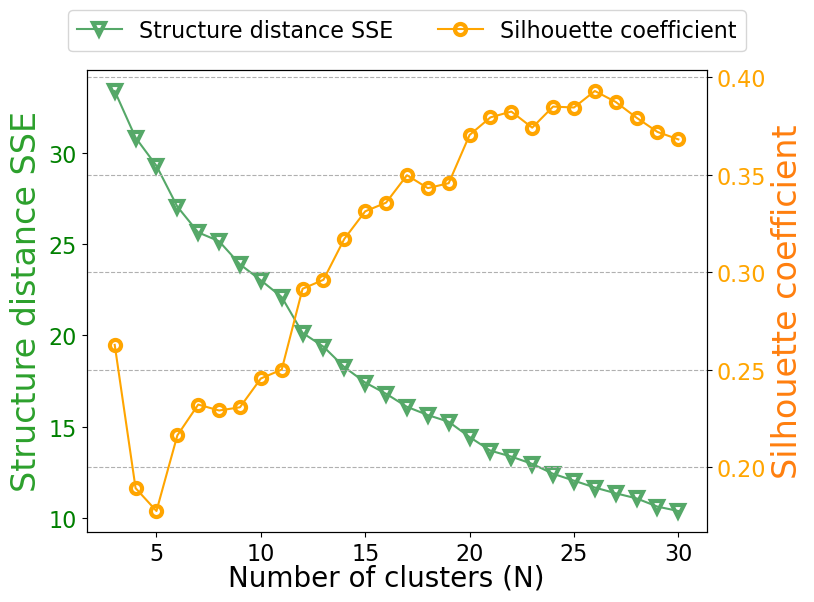

In [ ]:
# groups = [i[1].index.tolist() for i in cluster.groupby(cluster)]
# Silhouette(BA_Mat, groups)
ALL_SSE, _, ALL_Silhouette, _ = Tuning_N(BA_Mat, None, 3, 30, StructSilhouette=True)
xx = range(3, 31)

fig, ax1 = plt.subplots(figsize=(8,6))

# ax1 = axes[0]
ax2 = ax1.twinx()

line1, = ax1.plot(xx, ALL_SSE, c='g', marker='v', mfc='None', mec='g', ms='8', mew=3, label="Structure distance SSE")
line2, = ax2.plot(xx, ALL_Silhouette, c='orange', marker='o', mfc='None', mec='orange', ms=8, mew=3, label="Silhouette coefficient")

ax1.set_ylabel('Structure distance SSE', color='tab:green', fontsize=24)
ax2.set_ylabel('Silhouette coefficient', color='tab:orange', fontsize=24)
# plt.legend()
# plt.tick_params('x', labelsize=16)
# plt.tick_params('y', labelsize=16)

ax1.tick_params(axis='y', labelcolor='green', labelsize=16)
ax1.tick_params(axis='x', labelsize=16)
ax2.tick_params(axis='y', labelcolor='orange', labelsize=16)

fig.supxlabel('Number of clusters (N)', fontsize=20)
# plt.ylabel('Structure Distance SSE', fontsize=20)
# plt.axvline(x=6, c='k', linestyle=':')
# plt.annotate('N=6', xy=(0.16, 0.05), xycoords='axes fraction', fontsize=16)
# plt.axvline(x=12, c='k', linestyle=':')
# plt.annotate('N=12', xy=(0.36, 0.05), xycoords='axes fraction', fontsize=16)
plt.grid(linestyle='--')

fig.legend([line1, line2], ["Structure distance SSE", "Silhouette coefficient"], prop={"size":16}, loc=9, ncol=2)

plt.show()

## All HLA I alleles

In [ ]:
# Mat = CGCalcMat("../HLA1_models/CG_DAT", "../Figures/Figure4_total_clustering/Fig4.list", contact=contact, weight=weight, sigma=0.1, w=4)
Mat = CGCalcMat("../HLA1_models/CG_DAT", "../Figures/Figure4_total_clustering/Fig4.list", contact=contact, weight=weight)
# print(Mat)
# heatmap(Mat, order=None, line=False, size=(80,80), shrink=0.8, aspect=40, pad=0.02)
# Matrix2Dendro(Mat, "HLA-I_cg.newick")
Mat.to_csv("HLA-I_cg_dist_cf.csv")

N=1  SE: 3330.1259078745884 / BE: NA / SS: 0 / BS: NA
N=2  SE: 3053.2729958441582 / BE: NA / SS: 0.16111841657018494 / BS: NA
N=3  SE: 2772.8448483772017 / BE: NA / SS: 0.2094456376131611 / BS: NA
N=4  SE: 2663.6200592045707 / BE: NA / SS: 0.21277382654933122 / BS: NA
N=5  SE: 2490.981182251954 / BE: NA / SS: 0.23487836851382776 / BS: NA
N=6  SE: 2431.6394036203615 / BE: NA / SS: 0.2234750038763509 / BS: NA
N=7  SE: 2384.019579606973 / BE: NA / SS: 0.23377860169466175 / BS: NA
N=8  SE: 2280.516273389347 / BE: NA / SS: 0.2416135633521765 / BS: NA
N=9  SE: 2227.835371541663 / BE: NA / SS: 0.2304950972836734 / BS: NA
N=10  SE: 2175.973508067696 / BE: NA / SS: 0.24043720131029292 / BS: NA
N=11  SE: 2142.0222030621544 / BE: NA / SS: 0.24377913560693026 / BS: NA
N=12  SE: 2068.484544811901 / BE: NA / SS: 0.23699874001587523 / BS: NA
N=13  SE: 2013.8512161091205 / BE: NA / SS: 0.23689006730627613 / BS: NA
N=14  SE: 1936.8184117823282 / BE: NA / SS: 0.25096540826478275 / BS: NA
N=15  SE: 1927.

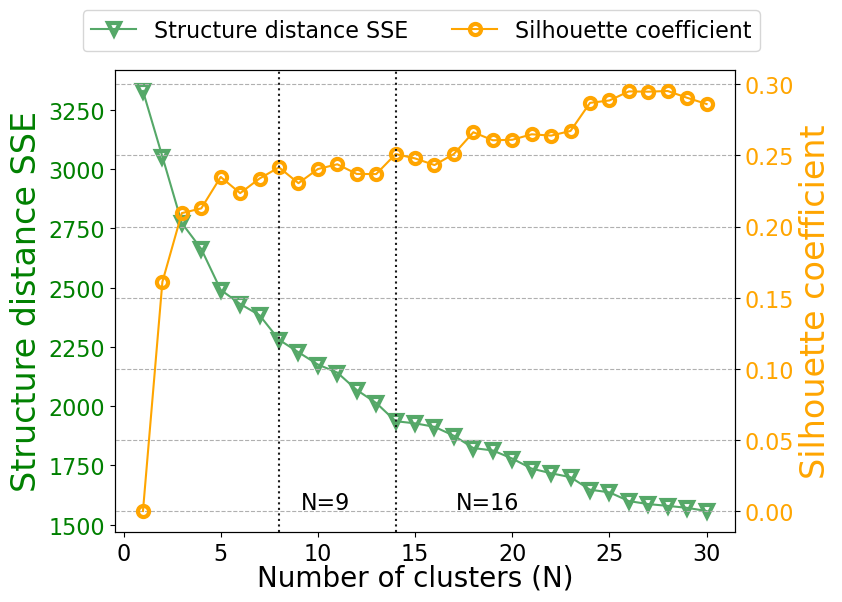

In [ ]:
# Mat = pd.read_csv("HLA-I_cg_dist.csv", index_col=0)
Mat = pd.read_csv("HLA-I_cg_dist_cf.csv", index_col=0)

SSE_struct, _, SilhouetteScore, _ = Tuning_N(Mat, None, 1, 30, StructSilhouette=True)
xx = range(1, 31)

fig, ax1 = plt.subplots(figsize=(8,6))

# ax1 = axes[0]
ax2 = ax1.twinx()

line1, = ax1.plot(xx, SSE_struct, c='g', marker='v', mfc='None', mec='g', ms='8', mew=3, label="Structure distance SSE")
line2, = ax2.plot(xx, SilhouetteScore, c='orange', marker='o', mfc='None', mec='orange', ms=8, mew=3, label="Silhouette coefficient")

ax1.set_ylabel('Structure distance SSE', color='green', fontsize=24)
ax2.set_ylabel('Silhouette coefficient', color='orange', fontsize=24)
# plt.legend()
# plt.tick_params('x', labelsize=16)
# plt.tick_params('y', labelsize=16)

ax1.tick_params(axis='y', labelcolor='green', labelsize=16)
ax1.tick_params(axis='x', labelsize=16)
ax2.tick_params(axis='y', labelcolor='orange', labelsize=16)

fig.supxlabel('Number of clusters (N)', fontsize=20)
# plt.ylabel('Structure Distance SSE', fontsize=20)
plt.axvline(x=8, c='k', linestyle=':')
plt.annotate('N=9', xy=(0.3, 0.05), xycoords='axes fraction', fontsize=16)
plt.axvline(x=14, c='k', linestyle=':')
plt.annotate('N=16', xy=(0.55, 0.05), xycoords='axes fraction', fontsize=16)
plt.grid(linestyle='--')

fig.legend([line1, line2], ["Structure distance SSE", "Silhouette coefficient"], prop={"size":16}, loc=9, ncol=2)

plt.show()

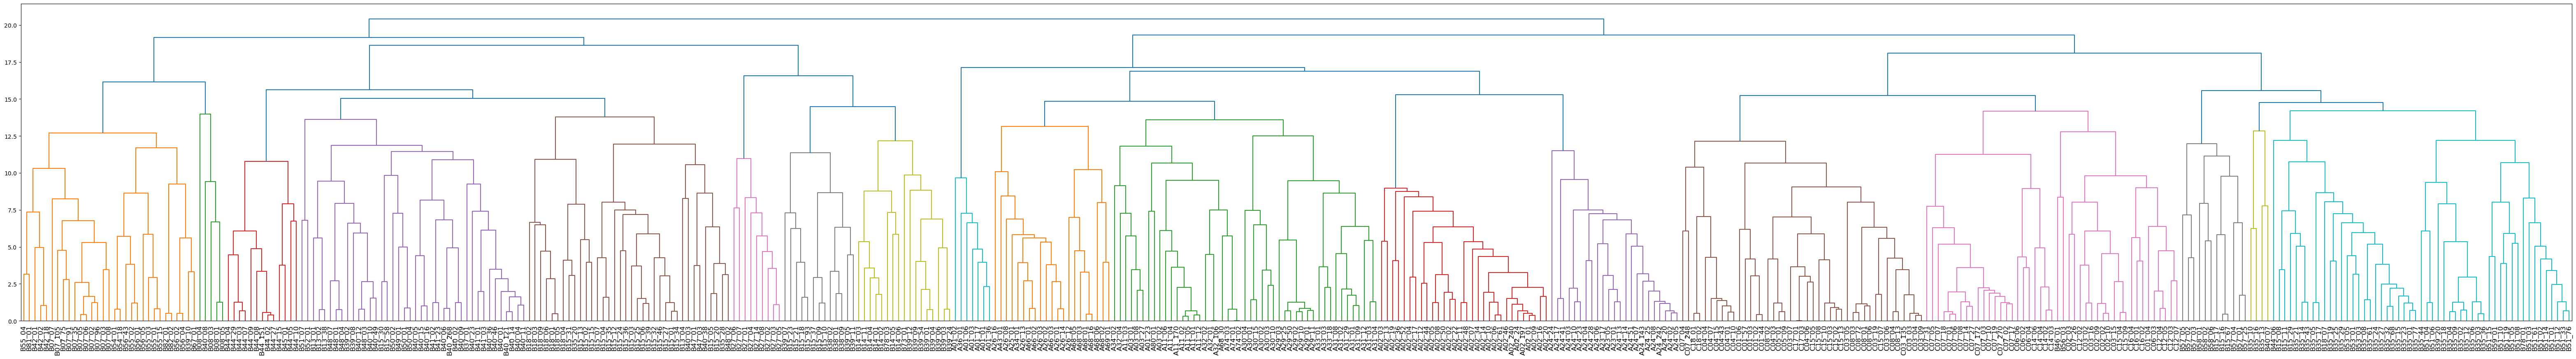

In [ ]:
Mat = pd.read_csv("HLA-I_cg_dist_cf.csv", index_col=0)
cluster, order = hierarchical_cluster(Mat, N=12, L='complete', color_threshold=None, plot_dendro=True, outtree="Fig4-12_cf.newick")

name_order = Mat.index[order].to_list()
group_dict = cluster.to_dict()

full_CG_order = []
temp_group = None
last_group = -1
for name in name_order:
    if group_dict[name] != last_group:
        temp_group = []
        full_CG_order.append(temp_group)

    temp_group.append(name)
    last_group = group_dict[name]

# print(full_CG_order)

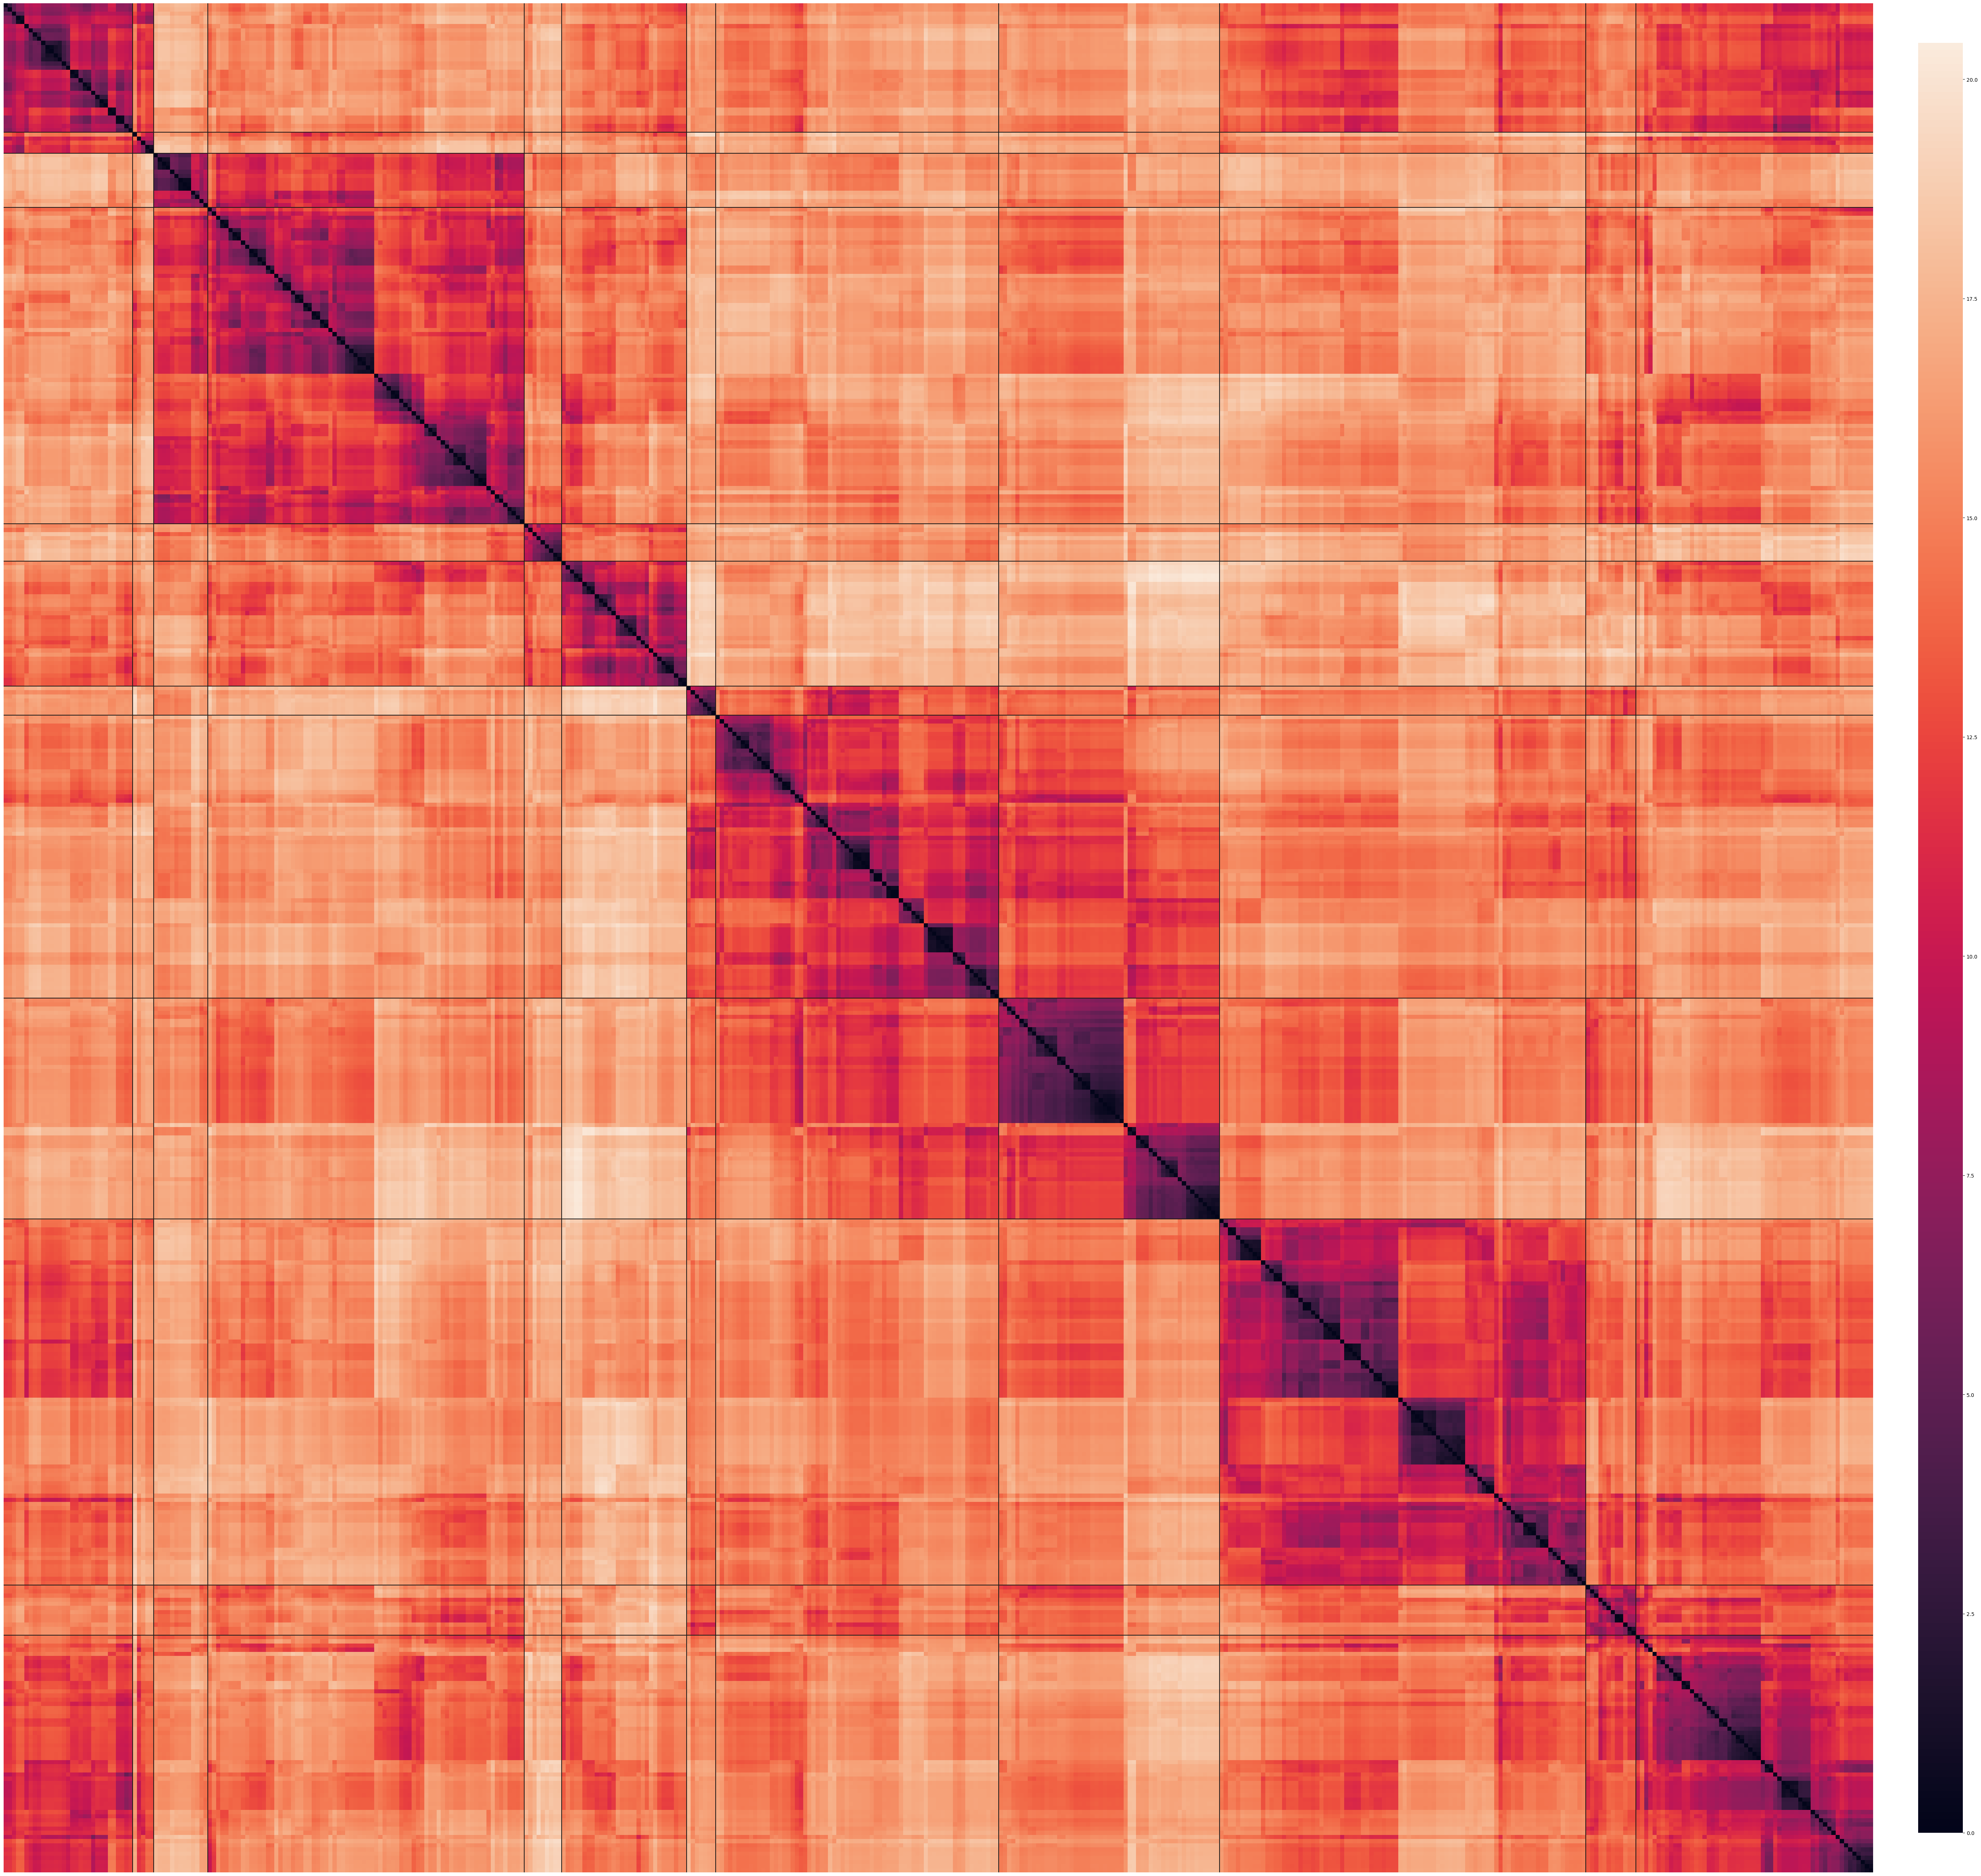

In [ ]:
heatmap(Mat, order=full_CG_order, size=(80,80), line=True, shrink=0.8, aspect=40, pad=0.02)

In [ ]:
print(cluster.to_string())

A01_01      6
A01_02      6
A01_03      6
A01_06      6
A01_17      6
A01_23      1
A01_36      6
A02_01      0
A02_02      0
A02_03      0
A02_04      0
A02_05      0
A02_06      0
A02_07      0
A02_08      0
A02_09      0
A02_10      0
A02_11      0
A02_12      0
A02_13      0
A02_14      0
A02_16      0
A02_17      0
A02_19      0
A02_197     0
A02_20      0
A02_22      0
A02_24      0
A02_240     0
A02_34      0
A02_36      0
A02_44      0
A02_46      0
A02_48      0
A02_50      0
A02_52      0
A02_61      0
A03_01      1
A03_02      1
A03_08      1
A03_27      1
A11_01      1
A11_02      1
A11_03      1
A11_04      1
A11_05      1
A11_06      1
A11_12      1
A11_170     1
A23_01      0
A23_05      0
A23_17      0
A24_02      0
A24_03      0
A24_04      0
A24_05      0
A24_06      0
A24_07      0
A24_08      0
A24_10      0
A24_13      0
A24_14      0
A24_143     0
A24_17      0
A24_20      0
A24_23      0
A24_24      0
A24_242     0
A24_25      0
A24_28      0
A24_41      0
A24_51